# Import Price Data From Kraken API:

In [57]:
import krakenex 
from pykrakenapi import KrakenAPI
import sys
import time
import urllib.request
import json
import requests
import pandas as pd
import numpy as np 

# import hvplot
# import hvplot.pandas
from IPython.display import Markdown

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor

from ta.momentum import RSIIndicator

pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.width", 1000)

import warnings
warnings.filterwarnings('ignore')

In [58]:
api = krakenex.API()
k = KrakenAPI(api)

In [59]:
ohlc = k.get_ohlc_data("BTCUSD")

In [60]:
def fetch_OHLC_data(symbol, timeframe):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'
    response = requests.get(url)
    if response.status_code == 200: 
        j = json.loads(response.text)
        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])
        else:
            data = pd.DataFrame(result[keys[1]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])

        data['date'] = pd.to_datetime(data['unix'], unit='s')
        data['volume_from'] = data['volume'].astype(float) * data['close'].astype(float)
    return data

In [61]:
btc = fetch_OHLC_data(symbol="BTC/USD", timeframe="1440")
btc = btc.drop(columns=["unix", "open", "high", "low", "volume_from"])
btc = btc.set_index("date")
btc['close'] = btc['close'].astype(float)
btc['returns'] = btc.close.pct_change()
btc['change_in_price'] = btc['returns']
btc.change_in_price[btc.change_in_price > 0] = 1
btc.change_in_price[btc.change_in_price <= 0] = 0
btc.dropna(inplace=True)
btc['change_in_price'] = btc['change_in_price'].astype(int)
btc.head()

,close,vwap,volume,tradecount,returns,change_in_price
date,,,,,,
2019-07-02,10837.3,10265.1,15317.90208157,51153,0.024717,1
2019-07-03,11979.8,11357.7,16123.60034549,52160,0.105423,1
2019-07-04,11148.3,11676.8,7856.19947708,31922,-0.069409,0
2019-07-05,11006.0,11105.0,8055.43677022,30004,-0.012764,0
2019-07-06,11233.5,11402.3,5353.27428748,21980,0.020671,1


# Generate Quantitative Trading Signals:

In [62]:
def generate_signals(btc):
    """Generates trading signals for a given dataset."""
    signals_df = btc.copy()
    # Set the short window and long windows
    short_window = 50
    long_window = 100

    # Generate the short and long moving averages signal (50 and 100 days, respectively)
    signals_df["SMA50"] = signals_df["close"].rolling(window=short_window).mean()
    signals_df["SMA100"] = signals_df["close"].rolling(window=long_window).mean()

    signals_df["long_sig"] = np.where(signals_df["SMA50"] > signals_df["SMA100"], 1.0, 0.0)
    signals_df["short_sig"] = np.where(signals_df["SMA50"] < signals_df["SMA100"], -1.0, 0.0)
    signals_df["SMA_signal"] = signals_df["long_sig"] + signals_df["short_sig"]
    
    # Calculate bollinger bands and upper and lowers bands of bollinger band and bollinger band signal
    signals_df['bollinger_mid_band'] = signals_df['close'].rolling(window=20).mean()
    signals_df['bollinger_std'] = signals_df['close'].rolling(window=20).std()

    signals_df['bollinger_upper_band']  = signals_df['bollinger_mid_band'] + (signals_df['bollinger_std'] * 1)
    signals_df['bollinger_lower_band']  = signals_df['bollinger_mid_band'] - (signals_df['bollinger_std'] * 1)

    signals_df['bollinger_long'] = np.where(signals_df['close'] < signals_df['bollinger_lower_band'], 1.0, 0.0)
    signals_df['bollinger_short'] = np.where(signals_df['close'] > signals_df['bollinger_upper_band'], -1.0, 0.0)
    signals_df['bollinger_signal'] = signals_df['bollinger_long'] + signals_df['bollinger_short']
    
    # Calculate RSI and RSI signals
    rsi_14 = RSIIndicator(close = signals_df.close, window = 14)
    signals_df["RSI"] = rsi_14.rsi()
    signals_df["RSI_long"] = np.where(signals_df["RSI"] < 30, 1.0, 0.0)
    signals_df["RSI_short"] = np.where(signals_df["RSI"] > 70, -1.0, 0.0)
    signals_df["RSI_signal"] = signals_df["RSI_long"] + signals_df["RSI_short"]
    
    # Calculate VWAP and VWAP signals
    signals_df['vwap'] = signals_df['vwap'].astype(float)
    signals_df['volume'] = signals_df['volume'].astype(float)
    signals_df["VWAP_long"] = np.where(signals_df["close"] < signals_df["vwap"], 1.0, 0.0)
    signals_df["VWAP_short"] = np.where(signals_df["close"] > signals_df["vwap"], -1.0, 0.0)
    signals_df["VWAP_signal"] = signals_df["VWAP_short"] + signals_df["VWAP_long"]
    signals_df["VWAP_signal"] = signals_df['VWAP_signal'].astype(float)
    
    return signals_df

In [63]:
all_sig = generate_signals(btc)
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-15,40166.6,40284.8,6924.353529,53714,-0.008986,0,44333.526,50632.214,0.0,-1.0,-1.0,36854.275,1968.183017,38822.458017,34886.091983,0.0,-1.0,-1.0,52.344094,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-16,38337.1,39141.7,6487.206888,49793,-0.045548,0,43998.694,50491.835,0.0,-1.0,-1.0,36845.310,1960.607403,38805.917403,34884.702597,0.0,0.0,0.0,48.176194,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-17,38078.2,38433.4,6003.220618,47838,-0.006753,0,43662.272,50323.327,0.0,-1.0,-1.0,36965.025,1959.056666,38924.081666,35005.968334,0.0,0.0,0.0,47.598593,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-18,35824.0,36734.4,6558.468890,48363,-0.059199,0,43307.160,50123.057,0.0,-1.0,-1.0,37025.395,1900.610770,38926.005770,35124.784230,0.0,0.0,0.0,42.788358,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-19,36204.9,35670.4,2052.022611,19501,0.010633,1,42875.658,49907.007,0.0,-1.0,-1.0,37051.950,1884.373473,38936.323473,35167.576527,0.0,0.0,0.0,43.821466,0.0,0.0,0.0,0.0,-1.0,-1.0


In [64]:
all_sig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719 entries, 2019-07-02 to 2021-06-19
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   close                 719 non-null    float64
 1   vwap                  719 non-null    float64
 2   volume                719 non-null    float64
 3   tradecount            719 non-null    int64  
 4   returns               719 non-null    float64
 5   change_in_price       719 non-null    int32  
 6   SMA50                 670 non-null    float64
 7   SMA100                620 non-null    float64
 8   long_sig              719 non-null    float64
 9   short_sig             719 non-null    float64
 10  SMA_signal            719 non-null    float64
 11  bollinger_mid_band    700 non-null    float64
 12  bollinger_std         700 non-null    float64
 13  bollinger_upper_band  700 non-null    float64
 14  bollinger_lower_band  700 non-null    float64
 15  boll

# Random Forest With Raw Variables

In [65]:
X = all_sig.copy()
X.dropna(inplace=True)
X.drop(columns=['close','returns','change_in_price'], inplace=True)
X.head(20)

,vwap,volume,tradecount,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,
2019-10-09,8431.2,6095.515667,17114,9553.148,10175.515,0.0,-1.0,-1.0,8588.855,730.326464,9319.181464,7858.528536,0.0,0.0,0.0,44.883605,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-10-10,8556.0,4491.796465,11427,9522.420,10153.028,0.0,-1.0,-1.0,8509.620,628.202471,9137.822471,7881.417529,0.0,0.0,0.0,44.843341,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-10-11,8451.4,6684.488360,17586,9485.674,10115.936,0.0,-1.0,-1.0,8424.230,525.763374,8949.993374,7898.466626,0.0,0.0,0.0,39.348577,0.0,0.0,0.0,1.0,0.0,1.0
2019-10-12,8341.2,1335.947944,5817,9443.650,10087.504,0.0,-1.0,-1.0,8338.030,365.778968,8703.808968,7972.251032,0.0,0.0,0.0,40.204620,0.0,0.0,0.0,1.0,0.0,1.0
2019-10-13,8317.8,2659.779268,9144,9406.440,10060.244,0.0,-1.0,-1.0,8267.685,181.664764,8449.349764,8086.020236,0.0,0.0,0.0,39.764883,0.0,0.0,0.0,1.0,0.0,1.0
2019-10-14,8310.1,2175.195131,7377,9370.842,10031.455,0.0,-1.0,-1.0,8258.580,171.765871,8430.345871,8086.814129,0.0,0.0,0.0,41.802268,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-10-15,8230.8,3446.285579,10370,9326.840,9998.293,0.0,-1.0,-1.0,8244.855,167.504741,8412.359741,8077.350259,0.0,0.0,0.0,38.251668,0.0,0.0,0.0,1.0,0.0,1.0
2019-10-16,8018.9,4175.765136,10395,9283.294,9955.313,0.0,-1.0,-1.0,8241.840,171.496593,8413.336593,8070.343407,1.0,0.0,1.0,35.445991,0.0,0.0,0.0,1.0,0.0,1.0
2019-10-17,8043.6,3371.348395,8901,9250.514,9910.379,0.0,-1.0,-1.0,8235.895,175.190370,8411.085370,8060.704630,0.0,0.0,0.0,37.750591,0.0,0.0,0.0,0.0,-1.0,-1.0


In [66]:
y=all_sig['change_in_price'].values.reshape(-1,1)
y=y[99:]
y[:5]

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [68]:
scaler = StandardScaler()

In [69]:
X_scaler = scaler.fit(X_train)

In [70]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [71]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [72]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [73]:
predictions = rf_model.predict(X_test_scaled)

In [74]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

acc_score = accuracy_score(y_test, predictions)

In [75]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,49,23
Actual 1,12,71


Accuracy Score : 0.7741935483870968
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.68      0.74        72
           1       0.76      0.86      0.80        83

    accuracy                           0.77       155
   macro avg       0.78      0.77      0.77       155
weighted avg       0.78      0.77      0.77       155



In [76]:
importances = rf_model.feature_importances_

In [77]:
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

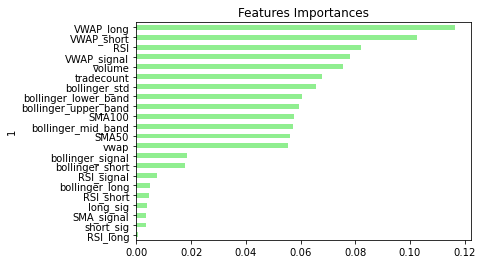

In [78]:
importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances.set_index(importances[1], inplace=True)
importances.drop(columns=1, inplace=True)
importances.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Random Forest Predictions Selecting The Three Most Significant Signals

In [79]:
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-15,40166.6,40284.8,6924.353529,53714,-0.008986,0,44333.526,50632.214,0.0,-1.0,-1.0,36854.275,1968.183017,38822.458017,34886.091983,0.0,-1.0,-1.0,52.344094,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-16,38337.1,39141.7,6487.206888,49793,-0.045548,0,43998.694,50491.835,0.0,-1.0,-1.0,36845.310,1960.607403,38805.917403,34884.702597,0.0,0.0,0.0,48.176194,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-17,38078.2,38433.4,6003.220618,47838,-0.006753,0,43662.272,50323.327,0.0,-1.0,-1.0,36965.025,1959.056666,38924.081666,35005.968334,0.0,0.0,0.0,47.598593,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-18,35824.0,36734.4,6558.468890,48363,-0.059199,0,43307.160,50123.057,0.0,-1.0,-1.0,37025.395,1900.610770,38926.005770,35124.784230,0.0,0.0,0.0,42.788358,0.0,0.0,0.0,1.0,0.0,1.0
2021-06-19,36204.9,35670.4,2052.022611,19501,0.010633,1,42875.658,49907.007,0.0,-1.0,-1.0,37051.950,1884.373473,38936.323473,35167.576527,0.0,0.0,0.0,43.821466,0.0,0.0,0.0,0.0,-1.0,-1.0


In [80]:
x_var_list = ['RSI_signal', 'bollinger_signal', 'VWAP_signal']
all_sig[x_var_list].tail()

,RSI_signal,bollinger_signal,VWAP_signal
date,,,
2021-06-15,0.0,-1.0,1.0
2021-06-16,0.0,0.0,1.0
2021-06-17,0.0,0.0,1.0
2021-06-18,0.0,0.0,1.0
2021-06-19,0.0,0.0,-1.0


In [81]:
all_sig.dropna(subset=x_var_list, inplace=True)
all_sig.dropna(subset=['returns'],inplace=True)
all_sig = all_sig.replace([np.inf, -np.inf], np.nan)
all_sig.head()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-02,10837.3,10265.1,15317.902082,51153,0.024717,1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-07-03,11979.8,11357.7,16123.600345,52160,0.105423,1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,-1.0,-1.0
2019-07-04,11148.3,11676.8,7856.199477,31922,-0.069409,0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0
2019-07-05,11006.0,11105.0,8055.436770,30004,-0.012764,0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0
2019-07-06,11233.5,11402.3,5353.274287,21980,0.020671,1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0


In [82]:
all_sig['Positive Return'] = np.where(all_sig['returns'] > 0, 1.0, 0.0)
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,long_sig,short_sig,SMA_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_long,VWAP_short,VWAP_signal,Positive Return
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-15,40166.6,40284.8,6924.353529,53714,-0.008986,0,44333.526,50632.214,0.0,-1.0,-1.0,36854.275,1968.183017,38822.458017,34886.091983,0.0,-1.0,-1.0,52.344094,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2021-06-16,38337.1,39141.7,6487.206888,49793,-0.045548,0,43998.694,50491.835,0.0,-1.0,-1.0,36845.310,1960.607403,38805.917403,34884.702597,0.0,0.0,0.0,48.176194,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2021-06-17,38078.2,38433.4,6003.220618,47838,-0.006753,0,43662.272,50323.327,0.0,-1.0,-1.0,36965.025,1959.056666,38924.081666,35005.968334,0.0,0.0,0.0,47.598593,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2021-06-18,35824.0,36734.4,6558.468890,48363,-0.059199,0,43307.160,50123.057,0.0,-1.0,-1.0,37025.395,1900.610770,38926.005770,35124.784230,0.0,0.0,0.0,42.788358,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2021-06-19,36204.9,35670.4,2052.022611,19501,0.010633,1,42875.658,49907.007,0.0,-1.0,-1.0,37051.950,1884.373473,38936.323473,35167.576527,0.0,0.0,0.0,43.821466,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0


In [83]:
x_var = ['RSI_signal', 'bollinger_signal', 'VWAP_signal', 'Positive Return']
rf_df = all_sig[x_var]
rf_df.dropna(inplace=True)
X_test = rf_df[x_var_list]
y_test = rf_df["Positive Return"]

In [84]:
X_test.tail()

,RSI_signal,bollinger_signal,VWAP_signal
date,,,
2021-06-15,0.0,-1.0,1.0
2021-06-16,0.0,0.0,1.0
2021-06-17,0.0,0.0,1.0
2021-06-18,0.0,0.0,1.0
2021-06-19,0.0,0.0,-1.0


In [85]:
y_test.tail()

date
2021-06-15    0.0
2021-06-16    0.0
2021-06-17    0.0
2021-06-18    0.0
2021-06-19    1.0
Name: Positive Return, dtype: float64

In [86]:
rf_reg = RandomForestRegressor(n_estimators = 100, max_depth=3, random_state = 78)
rf_reg.fit(X_test, y_test);
pred = rf_reg.predict(X_test)

In [87]:
rf_df["Predict"] = pred
rf_df.tail()

,RSI_signal,bollinger_signal,VWAP_signal,Positive Return,Predict
date,,,,,
2021-06-15,0.0,-1.0,1.0,0.0,0.272100
2021-06-16,0.0,0.0,1.0,0.0,0.149206
2021-06-17,0.0,0.0,1.0,0.0,0.149206
2021-06-18,0.0,0.0,1.0,0.0,0.149206
2021-06-19,0.0,0.0,-1.0,1.0,0.730231


In [88]:
thresh = np.arange(0,1,0.1)
real_thresh = thresh[3]
rf_df['Binary Predict'] = np.where(rf_df["Predict"] > real_thresh, 1, 0)
rf_df.tail()

,RSI_signal,bollinger_signal,VWAP_signal,Positive Return,Predict,Binary Predict
date,,,,,,
2021-06-15,0.0,-1.0,1.0,0.0,0.272100,0
2021-06-16,0.0,0.0,1.0,0.0,0.149206,0
2021-06-17,0.0,0.0,1.0,0.0,0.149206,0
2021-06-18,0.0,0.0,1.0,0.0,0.149206,0
2021-06-19,0.0,0.0,-1.0,1.0,0.730231,1


In [89]:
predicted = rf_df["Binary Predict"]

In [90]:
def assign_threshold(x):
    
    if x < 0.2:
        
        return 'sell'
    
    elif x >= 0.2 and x < 0.5:
        
        return 'hold'
    
    else:
                
        return 'buy'

In [91]:
rf_df['Recommend'] = rf_df['Predict'].apply(assign_threshold)
rf_df.tail(20)

,RSI_signal,bollinger_signal,VWAP_signal,Positive Return,Predict,Binary Predict,Recommend
date,,,,,,,
2021-05-31,0.0,0.0,-1.0,1.0,0.730231,1,buy
2021-06-01,0.0,0.0,1.0,0.0,0.149206,0,sell
2021-06-02,0.0,0.0,-1.0,1.0,0.730231,1,buy
2021-06-03,0.0,0.0,-1.0,1.0,0.730231,1,buy
2021-06-04,0.0,0.0,1.0,0.0,0.149206,0,sell
2021-06-05,0.0,0.0,1.0,0.0,0.149206,0,sell
2021-06-06,0.0,0.0,1.0,1.0,0.149206,0,sell
2021-06-07,0.0,1.0,1.0,0.0,0.129469,0,sell
2021-06-08,0.0,1.0,-1.0,0.0,0.567290,1,buy


In [92]:
Results = rf_df.drop(columns=['RSI_signal','bollinger_signal','VWAP_signal'])
Results.tail()

,Positive Return,Predict,Binary Predict,Recommend
date,,,,
2021-06-15,0.0,0.272100,0,hold
2021-06-16,0.0,0.149206,0,sell
2021-06-17,0.0,0.149206,0,sell
2021-06-18,0.0,0.149206,0,sell
2021-06-19,1.0,0.730231,1,buy


<AxesSubplot:xlabel='date'>

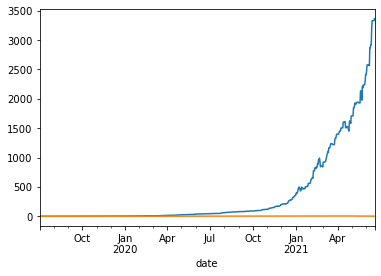

In [93]:
# Calculate cumulative return of model and plot the result
(1 + (all_sig['returns'] * Results['Binary Predict'])).cumprod().plot()
(1 + all_sig['returns']).cumprod().plot()

<AxesSubplot:xlabel='date'>

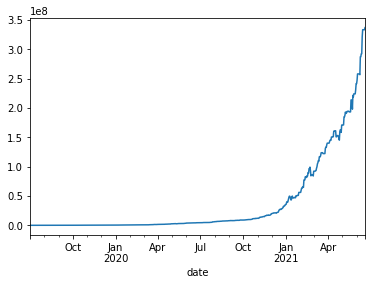

In [94]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (all_sig['returns'] * Results['Binary Predict'])).cumprod()
cumulative_return_capital.plot()

In [95]:
final_results = Results.drop(columns=['Positive Return','Predict','Binary Predict'])
final_results['close'] = all_sig['close']
final_results.head()

,Recommend,close
date,,
2019-07-02,buy,10837.3
2019-07-03,buy,11979.8
2019-07-04,sell,11148.3
2019-07-05,sell,11006.0
2019-07-06,sell,11233.5


In [96]:
trial_results = final_results.copy()
buy_hold_results = final_results.copy()

# Algo Trading Strategy: 100% allocation

In [97]:
wallet = 100000
equity = 0
num_coins = 0
wallet_history = []
equity_history = []
num_coins_history = []

for i in range(len(final_results)):


    if equity > 0 and final_results['Recommend'].iloc[i] == 'sell':

        wallet = num_coins * final_results['close'].iloc[i]
        equity = 0
        num_coins = 0
        
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)

    elif wallet > 0 and final_results['Recommend'].iloc[i] == 'buy':
        num_coins = wallet / final_results['close'].iloc[i]
        equity = num_coins * final_results['close'].iloc[i]
        wallet = 0
        
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
            
    else:
        equity = num_coins * final_results['close'].iloc[i]
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
        


In [98]:
final_results['wallet'] = wallet_history
final_results['share equity'] = equity_history
final_results['total equity'] = final_results['share equity'] + final_results['wallet']
final_results['num coins'] = num_coins_history

final_results.tail()

,Recommend,close,wallet,share equity,total equity,num coins
date,,,,,,
2021-06-15,hold,40166.6,0.000000,149348.399849,149348.399849,3.718224
2021-06-16,sell,38337.1,142545.909782,0.000000,142545.909782,0.000000
2021-06-17,sell,38078.2,142545.909782,0.000000,142545.909782,0.000000
2021-06-18,sell,35824.0,142545.909782,0.000000,142545.909782,0.000000
2021-06-19,buy,36204.9,0.000000,142545.909782,142545.909782,3.937199


<AxesSubplot:xlabel='date', ylabel='cumulative return'>

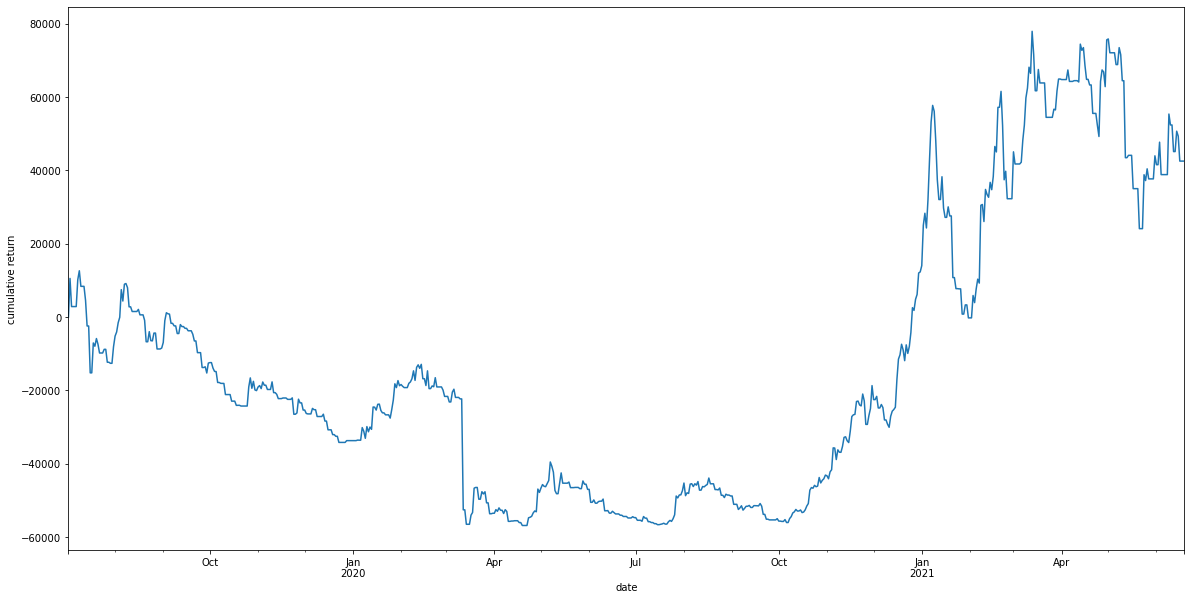

In [99]:
(final_results['total equity'] - 100000).plot(figsize=(20,10),ylabel='cumulative return')

# New Strategy: 20% allocation

In [100]:
wallet = 100000
equity = 0
num_coins = 0
wallet_history = []
equity_history = []
num_coins_history = []
trade_per = 0.2

for i in range(len(trial_results)):
    
    if equity > 0 and trial_results['Recommend'].iloc[i] == 'sell':
        coin_change = (equity * trade_per) / trial_results['close'].iloc[i]
        wallet = wallet + (coin_change * trial_results['close'].iloc[i])
        num_coins = num_coins - coin_change
        equity = num_coins * trial_results['close'].iloc[i]
        
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)

    elif wallet > 0 and trial_results['Recommend'].iloc[i] == 'buy':
        coin_change = (wallet * trade_per) / trial_results['close'].iloc[i] 
        wallet = wallet - (wallet * trade_per)
        num_coins = num_coins + coin_change
        equity = num_coins * trial_results['close'].iloc[i]

        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
                    
    else:
        equity = num_coins * trial_results['close'].iloc[i]
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
        

In [111]:
trial_results['wallet'] = wallet_history
trial_results['share equity'] = equity_history
trial_results['total equity'] = trial_results['share equity'] + trial_results['wallet']
trial_results['num coins'] = num_coins_history
trial_results['portfolio daily returns'] = trial_results['total equity'].pct_change()
trial_results['portfolio cumulative returns'] = trial_results['portfolio daily returns'].cumprod()

trial_results.tail()

,Recommend,close,wallet,share equity,total equity,num coins,portfolio daily returns,portfolio cumulative returns
date,,,,,,,,
2021-06-15,hold,40166.6,98526.037433,181252.603070,279778.640502,4.512520,-0.005840,-0.0
2021-06-16,sell,38337.1,134776.558047,136746.426331,271522.984377,3.566948,-0.029508,0.0
2021-06-17,sell,38078.2,162125.843313,108473.658334,270599.501647,2.848708,-0.003401,-0.0
2021-06-18,sell,35824.0,183820.574980,80357.369960,264177.944940,2.243116,-0.023731,0.0
2021-06-19,buy,36204.9,147056.459984,117975.887653,265032.347637,3.258561,0.003234,0.0


<AxesSubplot:xlabel='date', ylabel='cumulative return'>

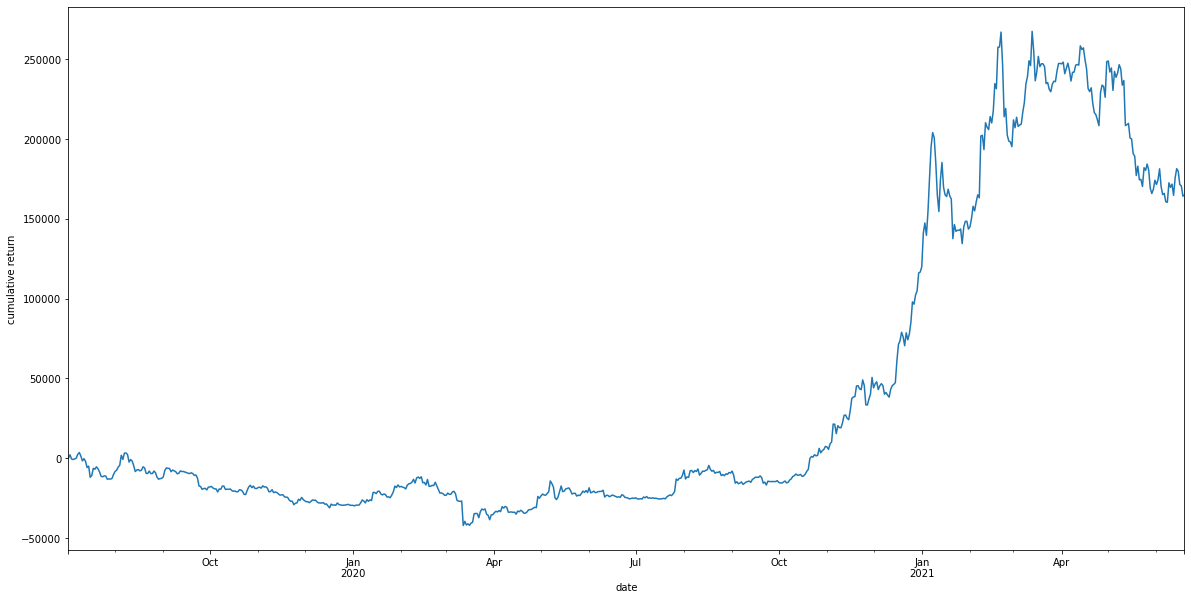

In [112]:
(trial_results['total equity'] - 100000).plot(figsize=(20,10),ylabel='cumulative return')

# Visualize Trading Strategy:

In [113]:
rf_df['close'] = all_sig['close']

# Visualize exit position relative to close price
exit = rf_df[rf_df['VWAP_signal'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = rf_df[rf_df['VWAP_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
coin_close = rf_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

vwap = all_sig[['vwap']].hvplot(ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = coin_close * vwap * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .Curve.II         :Curve   [date]   (vwap)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [114]:
# Visualize exit position relative to close price
exit = all_sig[all_sig['bollinger_signal'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = all_sig[all_sig['bollinger_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
coin_close = rf_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

bol_bands = all_sig[['bollinger_mid_band', 'bollinger_upper_band', 'bollinger_lower_band']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = coin_close * bol_bands * entry * exit
entry_exit_plot.opts(xaxis=None)


:Overlay
   .Curve.I          :Curve   [date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [115]:
# Visualize exit position relative to close price
exit = all_sig[all_sig['RSI_signal'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = all_sig[all_sig['RSI_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
coin_close = rf_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

RSI = all_sig[['RSI']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = coin_close * RSI * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .Curve.II         :Curve   [date]   (RSI)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [116]:
# Visualize exit position relative to close price
exit = rf_df[rf_df['Binary Predict'] == 0.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = rf_df[rf_df['Binary Predict'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
coin_close = rf_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = coin_close * RSI * entry * exit
entry_exit_plot.opts(xaxis=None)


:Overlay
   .Curve.I          :Curve   [date]   (close)
   .Curve.II         :Curve   [date]   (RSI)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [117]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [118]:
trial_results.head()

,Recommend,close,wallet,share equity,total equity,num coins,portfolio daily returns,portfolio cumulative returns
date,,,,,,,,
2019-07-02,buy,10837.3,80000.000000,20000.000000,100000.000000,1.845478,NaN,NaN
2019-07-03,buy,11979.8,64000.000000,38108.458749,102108.458749,3.181060,0.021085,2.108459e-02
2019-07-04,sell,11148.3,71621.691750,27841.715876,99463.407625,2.497396,-0.025904,-5.461821e-04
2019-07-05,sell,11006.0,77190.034925,21917.993300,99108.028225,1.991459,-0.003573,1.951490e-06
2019-07-06,sell,11233.5,81573.633585,17987.451471,99561.085055,1.601233,0.004571,8.920932e-09


In [119]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = trial_results['portfolio cumulative returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    trial_results['portfolio daily returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    trial_results['portfolio daily returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    trial_results['portfolio daily returns'].mean() * 252) / (
    trial_results['portfolio daily returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = trial_results[['portfolio daily returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

In [120]:
target = 0
mask = sortino_ratio_df['portfolio daily returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['portfolio daily returns']**2
portfolio_evaluation_df

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['portfolio daily returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

,Backtest
Annual Return,0.433793
Cumulative Returns,0.0
Annual Volatility,0.427077
Sharpe Ratio,1.015725
Sortino Ratio,1.539355


# Buy and Hold Strategy for comparison

In [121]:
wallet = 100000
equity = 0
num_coins = 0
wallet_history = []
equity_history = []
num_coins_history = []

for i in range(len(final_results)):
    
    if wallet > 0 and final_results['Recommend'].iloc[i] == 'buy':
        num_coins = wallet / buy_hold_results['close'].iloc[i]
        equity = num_coins * buy_hold_results['close'].iloc[i]
        wallet = 0
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)
    
    else:
        equity = num_coins * buy_hold_results['close'].iloc[i]
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_coins_history.append(num_coins)


In [122]:
buy_hold_results['wallet'] = wallet_history
buy_hold_results['share equity'] = equity_history
buy_hold_results['total equity'] = final_results['share equity'] + final_results['wallet']
buy_hold_results['num coins'] = num_coins_history

buy_hold_results.tail()

,Recommend,close,wallet,share equity,total equity,num coins
date,,,,,,
2021-06-15,hold,40166.6,0,370632.906720,149348.399849,9.227391
2021-06-16,sell,38337.1,0,353751.395643,142545.909782,9.227391
2021-06-17,sell,38078.2,0,351362.424220,142545.909782,9.227391
2021-06-18,sell,35824.0,0,330562.040361,142545.909782,9.227391
2021-06-19,buy,36204.9,0,334076.753435,142545.909782,9.227391


<AxesSubplot:xlabel='date', ylabel='cumulative return'>

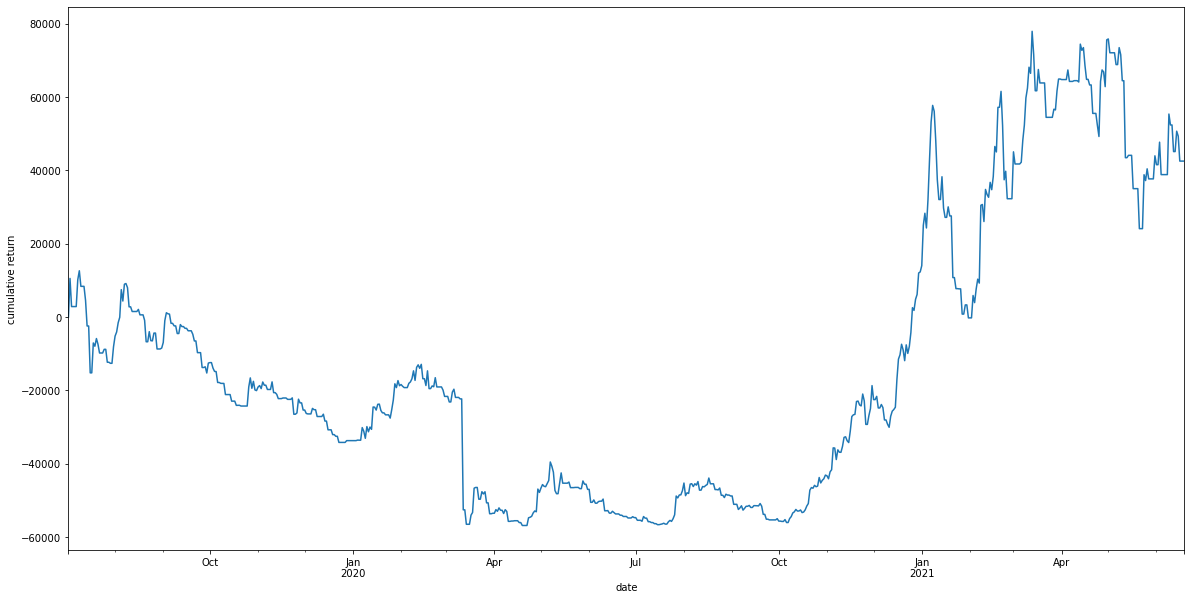

In [123]:
(buy_hold_results["total equity"]-100000).plot(figsize = (20,10),ylabel='cumulative return')

<AxesSubplot:xlabel='date', ylabel='cumulative return'>

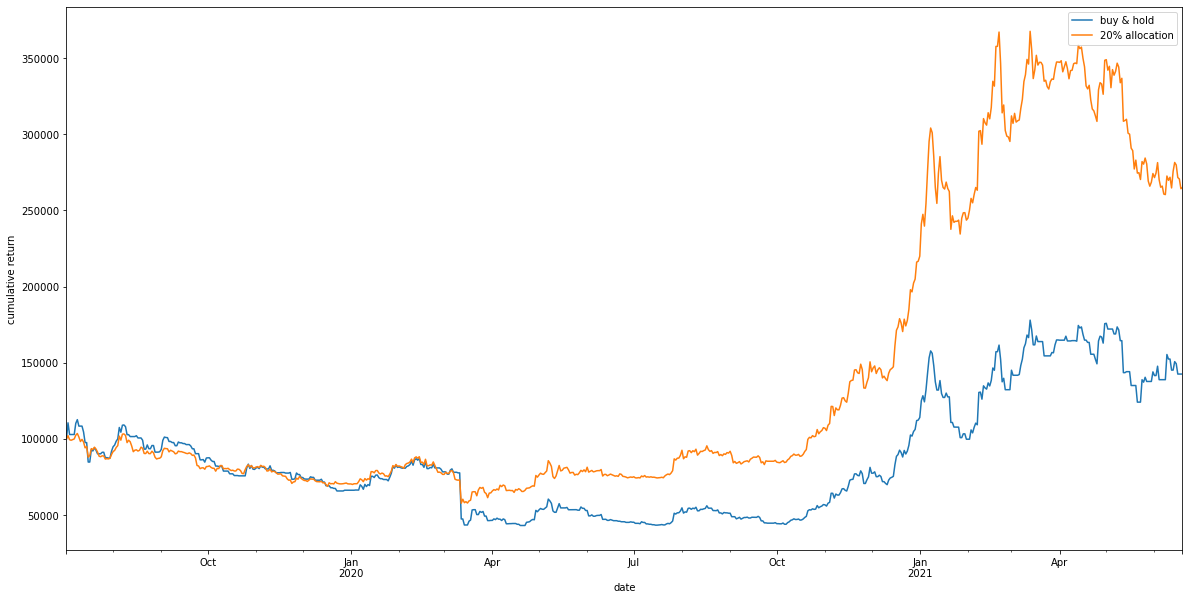

In [124]:
comparison = pd.merge(buy_hold_results["total equity"],trial_results['total equity'],on='date')
comparison.columns = ['buy & hold','20% allocation']
comparison.plot(figsize=(20,10),ylabel='cumulative return')